In [1]:
import pandas as pd

df = pd.DataFrame(pd.read_csv("Channels.csv"))

channels_dict=df.set_index('labels')['urchan']
channels_dict

labels
Fp1     1
Fp2     2
F3      3
F4      4
C3      5
       ..
PO8    63
Fpz    64
CPz    65
POz    66
Oz     67
Name: urchan, Length: 66, dtype: int64

In [2]:
import mne
import os
from pathlib import Path
import cupy
import numpy as np

In [3]:
data_dir = Path("data")

data_all = []
labels_all = []

os.environ['MNE_USE_CUDA'] = 'true' 
mne.utils.set_config('MNE_USE_CUDA', 'true') 
mne.cuda.init_cuda(ignore_config=True)  

Now using CUDA device 0
Enabling CUDA with 10.83 GB available memory


In [ ]:
# MIN_POINTS = 100  #Minimum number of time points per trial
# TARGET_SAMPLING_RATE = 250
# window_size=2500
# overlap=0.5
# for file_path in data_dir.glob("*.set"):
#         file_name = file_path.stem
#         if "PREP" not in file_name:
#             number = int(file_name.split('_')[0])
#             label = 1 if number % 2 == 1 else 0
            
#             # Load and preprocess the raw data
#             raw = mne.io.read_raw_eeglab(file_path, preload=True)
#             raw.set_eeg_reference('average', projection=True)
#             raw.resample(TARGET_SAMPLING_RATE, npad="auto")
#             raw.filter(1., 30., fir_design='firwin', n_jobs='cuda')
            
#             ica = mne.preprocessing.ICA(n_components=15, random_state=22, max_iter=1000, method='picard')
#             ica.fit(raw)
#             raw = ica.apply(raw)
            
#             data = raw.get_data().T  # (n_times, n_channels)
            
#             if data.shape[0] >= MIN_POINTS:
#                 # Create overlapping windows
#                 stride = int(window_size * (1 - overlap))
#                 for start in range(0, data.shape[0] - window_size + 1, stride):
#                     window = data[start:start + window_size, :]
#                     data_all.append(window)
#                     labels_all.append(label)
    
# data_all = np.stack(data_all)  # (n_windows, window_size, n_channels)
# labels_all = np.array(labels_all)

# # Check the shapes of the final dataset
# print("Final dataset shape:",data_all.shape,"(trials, time points, channels)")
# print("Labels shape:",labels_all.shape)

TARGET_SAMPLING_RATE = 250
window_size = 2500
overlap = 0.5 #50% overlap

for file_path in data_dir.glob("*.set"):
        file_name = file_path.stem
        if "PREP" not in file_name:
            number = int(file_name.split('_')[0])
            label = 1 if number % 2 == 1 else 0
            
            # Load and preprocess the raw data
            raw = mne.io.read_raw_eeglab(file_path, preload=True)
            raw.set_eeg_reference('average', projection=True)
            raw.resample(TARGET_SAMPLING_RATE, npad="auto",method="fft",n_jobs='cuda')
            raw.filter(1., 30., fir_design='firwin', n_jobs='cuda')
            
            ica = mne.preprocessing.ICA(n_components=15, random_state=22, max_iter=1000, method='picard')
            ica.fit(raw)
            raw = ica.apply(raw)
            
            data = raw.get_data().T  # (n_times, n_channels)
            
            #Only create windows if there's enough data for at least one window
            if data.shape[0] >= window_size:
                stride = int(window_size * (1 - overlap))
                for start in range(0, data.shape[0] - window_size + 1, stride):
                    window = data[start:start + window_size, :]
                    data_all.append(window)
                    labels_all.append(label)
            else:
                #Skip other trials
                print("Skipping trial:",file_name," - too short:",data.shape[0]," points")

data_all = np.stack(data_all)
labels_all = np.array(labels_all)

print("Final dataset shape:",data_all.shape,"(trials, time points, channels)")
print("Labels shape:",labels_all.shape)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Using CUDA for FFT resampling
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)

Using CUDA for FFT FIR filtering
Fitting ICA to data using 66 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.9s.
Applying ICA

C:\Users\Admin\AppData\Local\Temp\ipykernel_18080\2397413495.py:55: RuntimeWarning: Using n_components=15 (resulting in n_components_=15) may lead to an unstable mixing matrix estimation because the ratio between the largest (59) and smallest (8.6e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 8
  ica.fit(raw)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Using CUDA for FFT resampling
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)

Using CUDA for FFT FIR filtering
Fitting ICA to data using 66 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.3s.
Applying ICA

In [5]:
import torch
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [6]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.2, random_state=42)
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

X = data_all.reshape(data_all.shape[0], -1)
    
    # Split the data
X_train, X_test, y_train, y_test = train_test_split(X, labels_all, test_size=0.2, 
                                                       random_state=42, stratify=labels_all)


In [9]:
def train(model, train_dataloader, optimizer, criterion, print_freq=10):
    model.train()
    train_loss = 0
    
    for batch_index, (data, target) in enumerate(train_dataloader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        if batch_index % print_freq == 0:
            print(f"Batch {batch_index}, Loss: {loss.item():.4f}")
    
    return train_loss / len(train_dataloader)

def test(model, test_dataloader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_index, (data, target) in enumerate(test_dataloader):
            data, target = data.cuda(), target.cuda()

            output = model(data)
            test_loss += criterion(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataloader.dataset)
    test_accuracy = correct / len(test_dataloader.dataset)

    return test_loss, test_accuracy

def train_model(model, train_dataloader, test_dataloader, optimizer, criterion, num_epochs):
    loss_results = []
    accuracy_results = []
    train_loss_results=[]
    for epoch in range(num_epochs):
        train_loss = train(model, train_dataloader, optimizer, criterion)
        test_loss, test_accuracy = test(model, test_dataloader, criterion)

        print(
            f"Epoch: {epoch + 1} | Train loss: {train_loss:.5f} |",
            f"Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.5f}"
        )
        train_loss_results.append([epoch + 1, train_loss])
        accuracy_results.append([epoch + 1, test_accuracy])
        loss_results.append([epoch + 1, test_loss])
    return train_loss_results,accuracy_results, loss_results

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class EEGClassifier(nn.Module):
    def __init__(self, input_channels=66):
        super(EEGClassifier, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()        
        self.adaptive_pool = nn.AdaptiveAvgPool1d(100)

        self.fc1 = nn.Linear(64 * 100, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 2)
        
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)#New shape: (batch_size, channels, time_points)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.adaptive_pool(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        
        return x



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGClassifier(input_channels=66).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.01)
criterion = nn.CrossEntropyLoss()


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


train_loss_results,accuracy_results, loss_results = train_model(model=model,train_dataloader=train_loader,test_dataloader=test_loader,optimizer=optimizer,criterion=criterion,num_epochs=1000)

Batch 0, Loss: 0.7808
Batch 10, Loss: 0.6890
Batch 20, Loss: 0.7364
Batch 30, Loss: 0.5510
Batch 40, Loss: 0.6240
Batch 50, Loss: 0.6301
Batch 60, Loss: 0.5547
Batch 70, Loss: 0.7919
Batch 80, Loss: 0.6775
Batch 90, Loss: 0.5474
Epoch: 1 | Train loss: 0.74208 | Test loss: 0.37336 | Test accuracy: 0.51804
Batch 0, Loss: 0.6317
Batch 10, Loss: 0.6203
Batch 20, Loss: 0.6162
Batch 30, Loss: 0.3599
Batch 40, Loss: 0.6192
Batch 50, Loss: 0.4959
Batch 60, Loss: 0.6048
Batch 70, Loss: 0.3501
Batch 80, Loss: 0.5822
Batch 90, Loss: 0.4576
Epoch: 2 | Train loss: 0.59366 | Test loss: 0.71642 | Test accuracy: 0.52320
Batch 0, Loss: 0.5527
Batch 10, Loss: 0.5275
Batch 20, Loss: 0.5061
Batch 30, Loss: 0.4691
Batch 40, Loss: 0.5096
Batch 50, Loss: 0.6592
Batch 60, Loss: 0.4286
Batch 70, Loss: 0.4728
Batch 80, Loss: 0.4303
Batch 90, Loss: 0.5857
Epoch: 3 | Train loss: 0.51983 | Test loss: 1.30517 | Test accuracy: 0.48196
Batch 0, Loss: 0.3585
Batch 10, Loss: 0.4353
Batch 20, Loss: 0.4193
Batch 30, Loss

In [ ]:
from copy import deepcopy
proj_folder=Path("E:\\Penn State Homework\\Homework\\CMPSC\\CMPSC 445 Proj\\NNModel.pth")
torch.save(model.state_dict(), proj_folder)
best_model_state = deepcopy(model.state_dict())
torch.save(model.state_dict(), Path("E:\\Penn State Homework\\Homework\\CMPSC\\CMPSC 445 Proj\\DeepCopyNNModel.pth"))

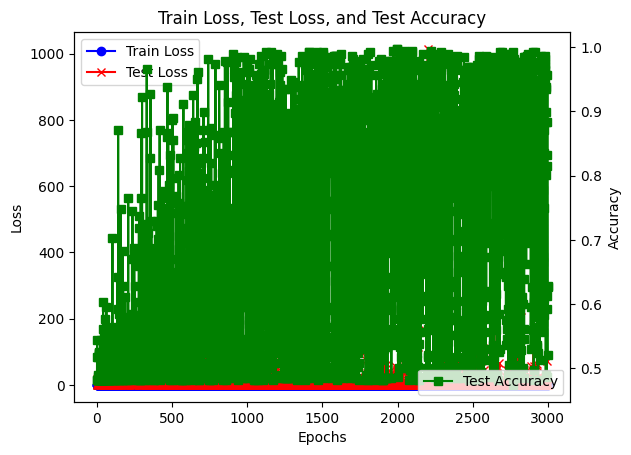

In [ ]:
import matplotlib.pyplot as plt
epochs=[tlr[0] for tlr in train_loss_results]
train_loss=[tlr[1] for tlr in train_loss_results]
test_accuracy=[acc[1] for acc in accuracy_results]
test_loss=[tlr[1] for tlr in loss_results]

fig, ax1 = plt.subplots()

#Train and Test Loss
ax1.plot(epochs, train_loss, label='Train Loss', color='b', marker='o')
ax1.plot(epochs, test_loss, label='Test Loss', color='r', marker='x')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

#Accuracy
ax2 = ax1.twinx()
ax2.plot(epochs, test_accuracy, label='Test Accuracy', color='g', marker='s')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

#Plot
plt.title('Train Loss, Test Loss, and Test Accuracy')
plt.show()

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics._scorer import _SCORERS
import joblib
def preprocess_data(X_train, X_test):
    #Flatten the data
    # X_train_flat = X_train.reshape(X_train.shape[0], -1)
    # X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    #Scale the data
    scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train_flat)
    # X_test_scaled = scaler.transform(X_test_flat)
    X_train_scaled=scaler.fit_transform(X_train)
    X_test_scaled=scaler.transform(X_test)
    joblib.dump(scaler, 'scaler.gz')
    return X_train_scaled, X_test_scaled

def train_logistic_regression(X_train_scaled, y_train, X_test_scaled, y_test):
    lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
    lr_model.fit(X_train_scaled, y_train)
    
    return lr_model

def train_logistic_regression_with_cv(X, y, cv_folds=5):
    lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    scores = cross_validate(
        lr_model, X, y, cv=cv, scoring=['accuracy', 'precision','f1','recall'],
        return_train_score=True, return_estimator=True
    )
    # scores = cross_validate(
    #     lr_model, X, y, cv=cv, scoring=_SCORERS,
    #     return_train_score=True, return_estimator=True
    # )
    # print("Cross-Validation Results:")
    # for key in scores.keys():
    #     print(key,":",scores[key])
    #Return the model with the best performance on validation data
    best_model_index = np.argmax(scores['test_accuracy'])
    best_model = scores['estimator'][best_model_index]
    
    return best_model

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
label_map = {'0': "Non-Parkinson's", '1': "Parkinson's"}

In [11]:
def display_classification_report(y_true,y_pred,beautiful=True):
    if (not beautiful):
        print(classification_report(y_true, y_pred))
    else:
        report=classification_report(y_true,y_pred,output_dict=True)
        
        report_df = pd.DataFrame(report)
        report_labels=list(report_df.columns)
        report_df=report_df.T
        
        report_labels[0]="Non-Parkinson's"
        report_labels[1]="Parkinson's"
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True,yticklabels=report_labels)  # Exclude 'accuracy' row and support column if undesired
        plt.title('Classification Report Heatmap')
        plt.xlabel('Metrics')
        plt.ylabel('Classes')
        plt.show()
        
def display_confusion_matrix(y_true,y_pred,beautiful=True):
    if (not beautiful):
        print(confusion_matrix(y_true, y_pred))
    else:
        matrix=confusion_matrix(y_true,y_pred)
        
        matrix_df = pd.DataFrame(matrix)
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(matrix_df, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True,xticklabels=["Parkinson's","Non-Parkinson's"],yticklabels=["Parkinson's","Non-Parkinson's"])  # Exclude 'accuracy' row and support column if undesired
        plt.title('Confusion Heatmap')
        plt.xlabel('Metrics')
        plt.ylabel('Classes')
        plt.show()

Training Logistic Regression with cv...

Logistic Regression with cv Results:


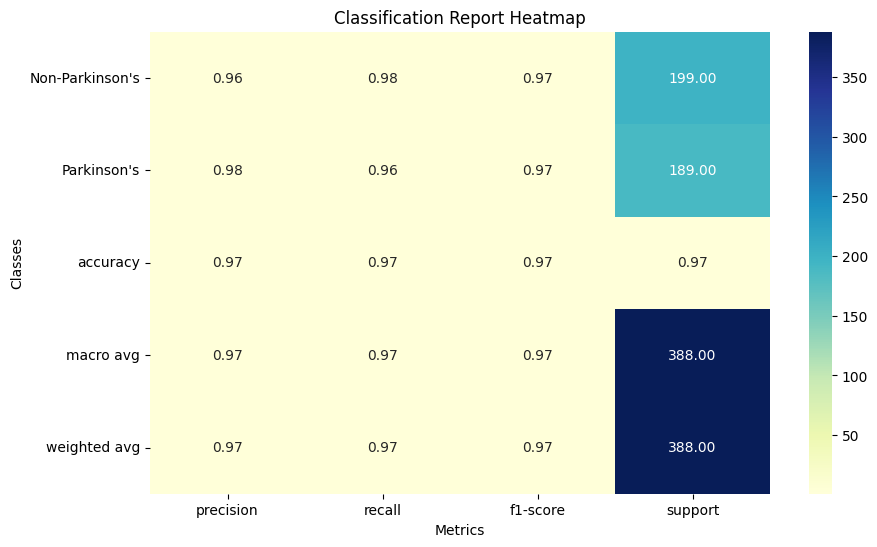

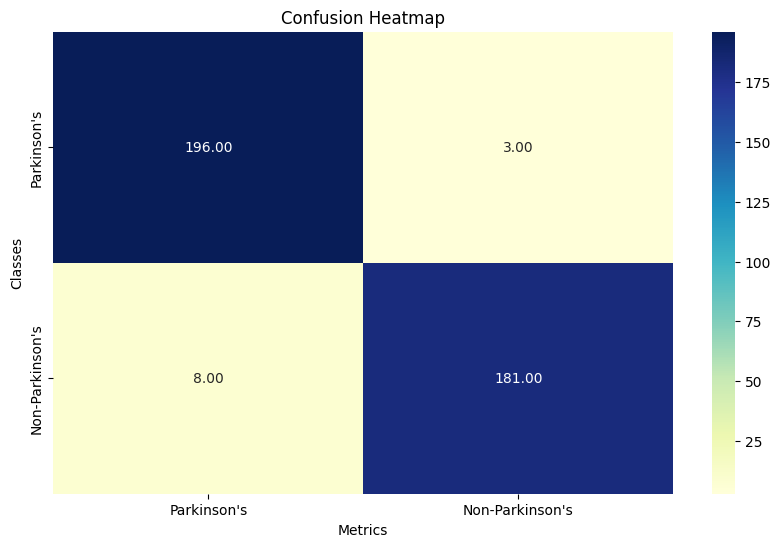

In [13]:
def run_comparison(X_train, X_test, y_train, y_test):
    #Logistic Regression
    print("Training Logistic Regression...")
    X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)
    lr_model = train_logistic_regression(X_train_scaled, y_train, X_test_scaled, y_test)
    y_pred = lr_model.predict(X_test_scaled)
    print("\nLogistic Regression Results:")
    display_classification_report(y_true=y_test,y_pred=y_pred,beautiful=False)
    display_confusion_matrix(y_true=y_test,y_pred=y_pred,beautiful=False)
    
    #Logistic Regression with cv
    print("Training Logistic Regression with cv...")
    X_combined = np.vstack((X_train_scaled, X_test_scaled))
    y_combined = np.hstack((y_train, y_test))
    best_model= train_logistic_regression_with_cv(X_combined, y_combined, cv_folds=20)
    y_pred = best_model.predict(X_test_scaled)
    print("\nLogistic Regression with cv Results:")
    display_classification_report(y_true=y_test,y_pred=y_pred,beautiful=False)
    display_confusion_matrix(y_true=y_test,y_pred=y_pred,beautiful=False)
    return lr_model, best_model

# lr_model, best_model = run_comparison(X_train, X_test, y_train, y_test)

# print("Training Logistic Regression...")
# X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)
# lr_model = train_logistic_regression(X_train_scaled, y_train, X_test_scaled, y_test)
# y_pred = lr_model.predict(X_test_scaled)
# print("\nLogistic Regression Results:")
# display_classification_report(y_true=y_test,y_pred=y_pred)
# display_confusion_matrix(y_true=y_test,y_pred=y_pred)

print("Training Logistic Regression with cv...")
X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)
X_combined = np.vstack((X_train_scaled, X_test_scaled))
y_combined = np.hstack((y_train, y_test))
best_model= train_logistic_regression_with_cv(X_combined, y_combined, cv_folds=20)
y_pred = best_model.predict(X_test_scaled)
print("\nLogistic Regression with cv Results:")
display_classification_report(y_true=y_test,y_pred=y_pred)
display_confusion_matrix(y_true=y_test,y_pred=y_pred)

In [13]:


filename = 'lr_cv.joblib'
joblib.dump(best_model, filename)



['lr_cv.joblib']

In [ ]:
'''
Similar to the logic inside the for-loop used for creating the dataset from all the .set files
'''
def process_single_file(file_path, window_size=2500):

    #Preprocessing steps
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    raw.set_eeg_reference('average', projection=True)
    raw.resample(TARGET_SAMPLING_RATE, npad="auto")
    raw.filter(1., 30., fir_design='firwin', n_jobs='cuda')
    
    ica = mne.preprocessing.ICA(n_components=15, random_state=22, max_iter=1000, method='picard')
    ica.fit(raw)
    raw = ica.apply(raw)
    
    data = raw.get_data().T
    
    #Make multiple windows
    windows = []
    stride = window_size // 2  #50% overlap
    for start in range(0, data.shape[0] - window_size + 1, stride):
        window = data[start:start + window_size, :]
        windows.append(window)
    
    return np.stack(windows)

#Predict a result for the input file
def predict_file(file_path, model, scaler, window_size=2500):
    windows = process_single_file(file_path, window_size)
    X = windows.reshape(windows.shape[0], -1)
    X_scaled = scaler.transform(X)
    
    #Predictions for all windows
    predictions = model.predict(X_scaled)
    probabilities = model.predict_proba(X_scaled)
    
    #Majority voting
    final_prediction = np.bincount(predictions).argmax()
    final_probability = np.mean(probabilities, axis=0)
    #file_prediction_prob_avg = np.argmax(final_probability)
    return final_prediction, final_probability


lr_model = joblib.load(filename)
# print(lr_model.n_features_in_)
file_path = "fresh data\\16_eyesOpen.set"
scaler=joblib.load('scaler.gz')
prediction, probability = predict_file(file_path, best_model, scaler, window_size=window_size)
prediction_label="Parkinson's" if prediction == 1 else "Non-Parkinson's"
print("Prediction:",prediction_label)
print("Confidence:",max(probability)*100,"%")
# print("Prob Avg:",prob_avg)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)

Using CUDA for FFT FIR filtering
Fitting ICA to data using 66 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transform


Random Forest Results:


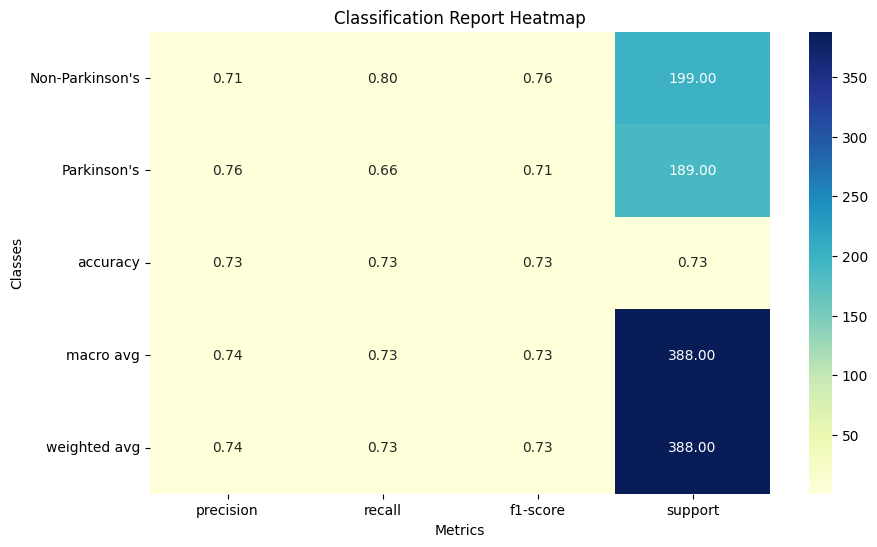

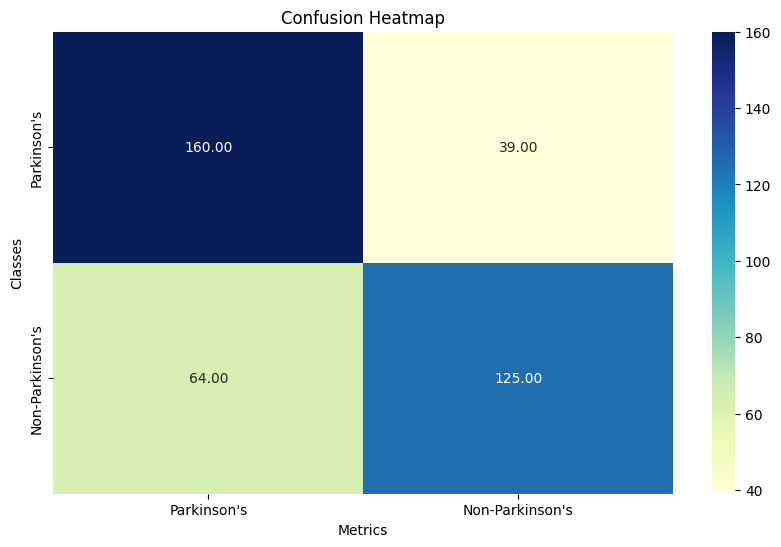

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
print("\nRandom Forest Results:")
display_classification_report(y_true=y_test,y_pred=rf_pred)
display_confusion_matrix(y_true=y_test,y_pred=rf_pred)
# # SVM
# svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
# svm_model.fit(X_train_scaled, y_train)
# svm_pred = svm_model.predict(X_test_scaled)
# print("\nSVM Results:")
# print(classification_report(y_test, svm_pred))


SVM Results:


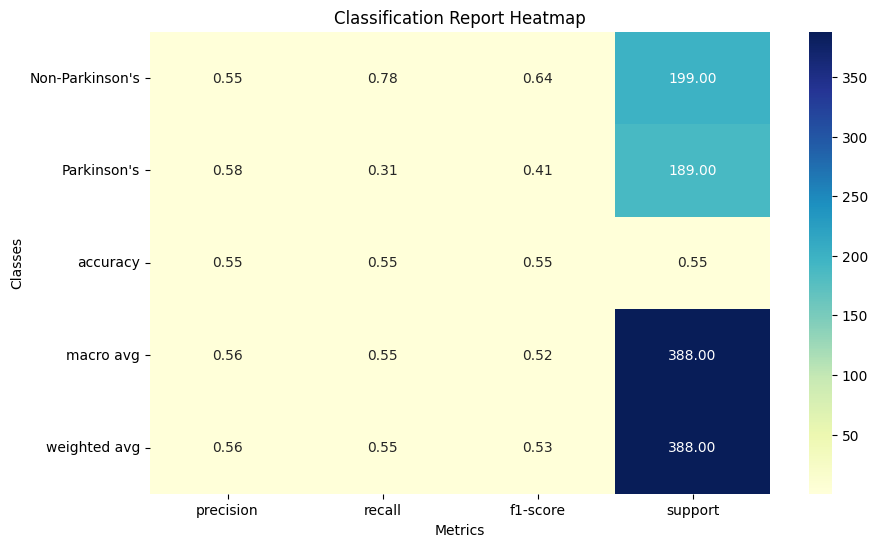

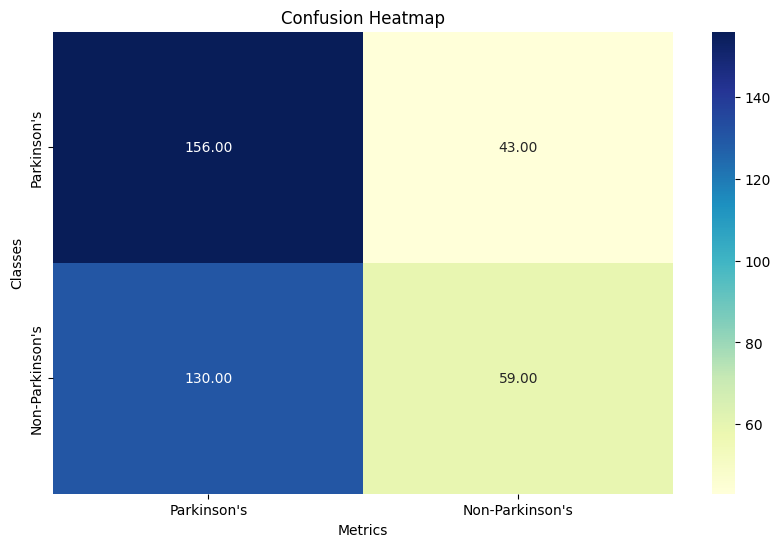

In [15]:
# SVM
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
print("\nSVM Results:")
display_classification_report(y_true=y_test,y_pred=svm_pred)
display_confusion_matrix(y_true=y_test,y_pred=svm_pred)

In [19]:
filename = 'rfc.joblib'
joblib.dump(rf_model, filename)

['rfc.joblib']

In [20]:
filename='svm.joblib'
joblib.dump(svm_model, filename)

['svm.joblib']

In [ ]:
print(confusion_matrix(y_test, svm_pred))
file_path = "fresh data\\32_eyesOpen.set"
scaler=joblib.load('scaler.gz')
prediction, probability = predict_file(file_path, svm_model, scaler, window_size=window_size)
prediction_label="Parkinson's" if prediction == 1 else "Non-Parkinson's"
print("Prediction:",prediction_label)
print("Confidence:",max(probability)*100,"%")

[[156  43]
 [130  59]]
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)

Using CUDA for FFT FIR filtering
Fitting ICA to data using 66 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.
Applying ICA to Raw